# Computing Lifetimes of Spiral Tips
Tim Tyree<br>
6.29.2020<br>

In [1]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pylab import imshow, show


import numba, trackpy
# from numba import njit, jit, vectorize
# from PIL import Image
# import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()

#load the libraries
from lib import *
from lib.dist_func import *
# from lib.operari import *
# from lib.ProgressBar import *
# from lib.minimal_model import *
# from lib.TexturePlot import *
# from lib.get_tips import *
# from lib.minimal_model import *
# from lib.intersection import *
# from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

100000
Automatic calling is: Smart


# import tip positions

In [628]:
sigma = 1.5  #1.5#1.5#1.#1
threshold = 0.9#0.6  #0.9#0.95
V_threshold = 0.5


# search_for_file()
data_dir    = f'{nb_dir}/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_{sigma}_threshold_{threshold}_processed.csv'
print(f"loading .csv of size {sys.getsizeof(data_dir)/10**3} KB.")
df = pd.read_csv(data_dir)

save_folder = '/'+os.path.join(*data_dir.split('/')[:-2])+'/trajectories/'
os.chdir(save_folder)
print(f"files will be saved in the folder: \n\t{save_folder}")

loading .csv of size 0.177 KB.
files will be saved in the folder: 
	/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/trajectories/


In [630]:
# test data has no odd spiral tips since the data has periodic boundary conditions
assert not (np.array(list(set(df.n.values)))%2==1).any()
print('no odd spiral tips exist.')

no odd spiral tips exist.


## DONE: get trackpy to use periodic boundary distances
- failing ^that make trackpy use my distance function

__Trackpy warns in its more seriptitious print statements that user defined distances are not tested__<br>
Thus, I must test my own use case on a test with a known response.

__How trackpy handles user defined distance functions__
The only appearance of dist_func in trackpy's source code from github is in subnet.py.  In which, trackpy.subnet.HashBTree.rebuild passes dist_func to sklearn as follows <br>
`sklearn.neighbors.BallTree(coords_mapped,metric='pyfunc', func=self.dist_func`

`sklearn.neighbors.BallTree` has func as an additional kwarg, which is passed to the distance metric class, DistanceMetric.  In the docstring of that function, I find the specification for `DistanceMetric`.

__Bottom Line Up Front (BLUF) the function must take two 1D numpy arrays and return a distance.  Everything will be slower because of the overhead of calling python functions__

In [87]:
# from sklearn.neighbors import BallTree, DistanceMetric

In [194]:
print('''**User-defined distance:**

===========    ===============    =======
identifier     class name         args
-----------    ---------------    -------
"pyfunc"       PyFuncDistance     func
===========    ===============    =======

Here ``func`` is a function which takes two one-dimensional numpy
arrays, and returns a distance.  Note that in order to be used within
the BallTree, the distance must be a true metric:
i.e. it must satisfy the following properties

1) Non-negativity: d(x, y) >= 0
2) Identity: d(x, y) = 0 if and only if x == y
3) Symmetry: d(x, y) = d(y, x)
4) Triangle Inequality: d(x, y) + d(y, z) >= d(x, z)

Because of the Python object overhead involved in calling the python
function, this will be fairly slow, but it will have the same
scaling as other distances.''')

**User-defined distance:**

===========    ===============    =======
identifier     class name         args
-----------    ---------------    -------
"pyfunc"       PyFuncDistance     func
===========    ===============    =======

Here ``func`` is a function which takes two one-dimensional numpy
arrays, and returns a distance.  Note that in order to be used within
the BallTree, the distance must be a true metric:
i.e. it must satisfy the following properties

1) Non-negativity: d(x, y) >= 0
2) Identity: d(x, y) = 0 if and only if x == y
3) Symmetry: d(x, y) = d(y, x)
4) Triangle Inequality: d(x, y) + d(y, z) >= d(x, z)

Because of the Python object overhead involved in calling the python
function, this will be fairly slow, but it will have the same
scaling as other distances.


In [156]:
# this section was sent to lib.dist_func
# def get_distance_L2_pbc(width=200,height=200):
#     '''returns a function for the euclidean (L2) distance measure for a 2D rectangle with periodic boundary conditions.
#     width, height are the shape of that 2D rectangle.'''
#     @jit('f8(f8[:],f8[:])', nopython=True)
#     def distance_L2_pbc(point_1, point_2):
#         '''assumes getting shortest distance between two points with periodic boundary conditions in 2D.'''
#         mesh_shape=np.array((width,height))
#         dq2 = 0.
#         #     for q1, q2, width in zip(point_1[:2], point_2[:2], mesh_shape):
#         for q1, q2, wid in zip(point_1, point_2, mesh_shape):
#             dq2 = dq2 + min(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
#         return np.sqrt(dq2)
#     return distance_L2_pbc

# def test_get_distance_L2_pbc():
#     import trackpy, pandas as pd

#     #testing the pbc distance function
#     distance_L2_pbc = get_distance_L2_pbc(width=200,height=200)
#     assert(np.isclose(distance_L2_pbc(np.array([1.,1.]),np.array([1.,1.])),0.))
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([199.,199.]))<3.)
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([199.,199.]))<3.)
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([1.,199.]))<3.)
#     assert(distance_L2_pbc(np.array([1.,1.]),np.array([199.,1.]))<3.)

#     #testing distance_L2_pbc in trackpy.link_df
#     df_test = pd.DataFrame({'frame':[1,2,2],'x':[1,100,199],'y':[1,100,199]})

#     # test that the default distance function maps 1,1 to 100,100 instead of 199,199
#     traj_test = trackpy.link_df(df_test, search_range=210)
#     assert((traj_test['particle'].values == np.array([0, 0, 1])).all())

#     # test that the pbc distance function maps 1,1 to 199,199 instead of 100,100
#     traj_test = trackpy.link_df(df_test, search_range=210, dist_func = distance_L2_pbc)
#     assert((traj_test['particle'].values == np.array([0, 1, 0])).all())

#     # test that the pbc distance function can see accross boundarys when search_range is small
#     traj_test = trackpy.link_df(df_test, search_range=110, dist_func = distance_L2_pbc)
#     assert((traj_test['particle'].values == np.array([0, 1, 0])).all())
#     return True

# track tips using periodic boundary conditions

In [631]:
# df_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_1.5_threshold_0.9_processed.csv'
# df = pd.read_csv(df_dir)


In [632]:
h = 0.007
mem = 2
sr  = 1
distance_L2_pbc = get_distance_L2_pbc(width=200,height=200)
link_kwargs = {
    'neighbor_strategy' : 'BTree',
    'dist_func'         : distance_L2_pbc,
    'memory': mem}

In [633]:
# boo = (550 < df.t) & (df.t < 555)
df['frame'] = df['t']/h
df = df.astype(dtype={'frame':int}).copy()
traj = trackpy.link_df(
    f=df,search_range=sr,t_column='frame', **link_kwargs)
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

Frame 79300: 2 trajectories present.


0

In [644]:
save_fn = os.path.basename(df_dir).replace('_processed.csv', f'_traj_sr_{sr}_mem_{mem}.csv')
traj.to_csv(save_fn, index=False)
print (save_fn)

tip_log_ds_5_sigma_1.5_threshold_0.9_traj_sr_1_mem_2.csv


Now compute life times

# compute life times

particles still not being tracked right.  debug between two  time steps from the middle frames ah, search_range must be at least ~1e-2.  Using 1e-0 should work

In [645]:
# data_fn = 'tip_log_ds_5_sigma_1.0_threshold_0.6_traj_sr_1.csv'
df_traj = pd.read_csv(save_fn)
print(save_fn)

tip_log_ds_5_sigma_1.5_threshold_0.9_traj_sr_1_mem_2.csv


In [646]:
df_traj.describe()

,n,t,x,y,frame,particle
count,286154.000000,286154.000000,286154.000000,286154.000000,286154.000000,286154.000000
mean,4.907945,214.309848,100.107927,108.412352,30615.490372,15035.585678
std,2.759621,164.702447,54.564645,62.542510,23528.923892,8057.475384
min,2.000000,0.007000,0.000373,0.024175,0.000000,0.000000
25%,2.000000,70.210000,56.942197,39.491929,10029.000000,8661.000000
50%,4.000000,161.546000,102.202295,126.617981,23078.000000,15002.500000
75%,6.000000,360.297000,145.294706,156.749566,51470.000000,21957.000000
max,14.000000,555.100000,199.998845,199.986341,79300.000000,28269.000000


In [672]:
# gd = g.describe()
# beep(2)


'hist_lifetimes_ds_5_sigma_1.5_threshold_0.9_traj_sr_1_mem_2.png'

In [649]:
g = df_traj.groupby('particle')['t']
mx = g.agg(np.max)
mn = g.agg(np.min)
gd_lifetimes = mx - mn

gd_lifetimes = gd['max']- gd['min']

# plot lifetimes

In [651]:
# ll=np.max(gd_lifetimes[gd_lifetimes>0.])
# print(f"the longest living tip lasted {int(np.around(ll/h))} time steps, which was {ll:.3f} ms.")

the longest living tip lasted 119 time steps, which was 0.833 ms.


 based on Wouter's results, we would expect a lifetime on the order of 10 ms from a birth/death rate of ~0.1/ms.  We have 557 ms of data, so we would expect on the order of 2*557*0.1=111 birth/death events.
 
 So, we expect at least one tip that lasts __10 ms__.

In [662]:
# plt.hist?

In [661]:
# plt.hist(out[out>-100], bins=30, density=True)

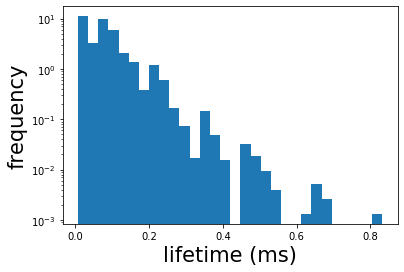

In [673]:
ll=np.max(gd_lifetimes[gd_lifetimes>0.])
print(f"the longest living tip lasted {int(np.around(ll/h))} time steps, which was {ll:.3f} ms.")
fig_fn = save_fn.replace('.csv','.png').replace('tip_log','hist_lifetimes')
# out = np.log(gd_lifetimes)
plt.hist(gd_lifetimes[gd_lifetimes>0], bins=30, density=True, log=True)
plt.ylabel('frequency', fontsize=21)
plt.xlabel('lifetime (ms)', fontsize=21)
# plt.show()
plt.savefig(fig_fn, dpi=300)

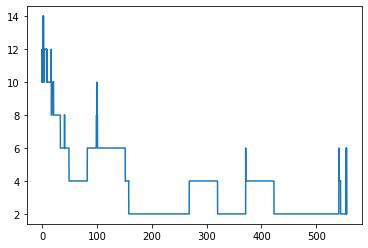

In [654]:
y_values = df_traj.n.values
x_values = df_traj.t.values
plt.plot(x_values,y_values)

In [625]:
# # (equivalently if pid's are not reused) take max and min time for each trajectory
# def get_lifetime(trajectory_list):
#     '''trajectory_list is a list of lists.  
#     return np.mean( [ len(trajectory) for trajectory in trajectory_list ], axis=0 )'''
#     return np.mean( [ len(trajectory) for trajectory in trajectory_list ], axis=0 )
# #    TODO: for a given .csv of tip positions, make their trajectories naively in trackpy


# TODO: take a close look at when those n = 6 numbers flicker to n=12 during trackpy.link_df
also, my data has some frames missing, and I don't know why...<br>
TODO: see if frames are still missing when `recording` is not recomputed every timestep

# DONE: walk through the log folder

In [719]:
log_dir = f"{nb_dir}/Data/ds_5_param_set_8/Log"
out_dir = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"

h = 0.007
mem = 2
sr  = 1
distance_L2_pbc = get_distance_L2_pbc(width=200,height=200)
df['frame'] = df['t']/h
df = df.astype(dtype={'frame':int}).copy()
link_kwargs = {
    'neighbor_strategy' : 'BTree',
    'dist_func'         : distance_L2_pbc,
    'memory': mem}

In [717]:
#compute all _processed.csv tip logs in the Log folder
os.chdir(log_dir)
for root, dirs, files in os.walk(".", topdown=False):
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        os.chdir(log_dir)
        df_dir = os.path.join(root, name)
        if df_dir.find('_processed.csv') !=-1:
            print(f"starting on {df_dir}...")
            df = pd.read_csv(df_dir)
            df['frame'] = df['t']/h
            df = df.astype(dtype={'frame':int}).copy()
            # test whether data has no odd spiral tips since the data has periodic boundary conditions
            if (np.array(list(set(df.n.values)))%2==1).any():
                print(f'WARNING: an odd spiral tips exists in \n\t{fn}')
            
            # compute trajectories (slowest part)
            traj = trackpy.link_df(f=df,search_range=sr,t_column='frame', **link_kwargs)
            
            #save results
            os.chdir(out_dir)
            save_fn = os.path.basename(df_dir).replace('_processed.csv', f'_traj_sr_{sr}_mem_{mem}.csv').replace('tip_log','tip_trajectories')
            traj.to_csv(save_fn, index=False)

Frame 79470: 2 trajectories present.


In [718]:
beep(7)

0

# make a histogram for each output 

In [720]:
sr  = 1
mem = 2
dpi = 300
traj_dir = f"{nb_dir}/Data/ds_5_param_set_8/trajectories"
save_dir = f"{nb_dir}/Figures"
os.chdir(traj_dir)
fontsize=21

In [721]:
#compute all _processed.csv tip logs in the Log folder
for root, dirs, files in os.walk(".", topdown=False):
    for name in dirs:
        print(os.path.join(root, name))
    for name in files:
        os.chdir(traj_dir)
        df_dir = os.path.join(root, name)
        if df_dir.find(f'_traj_sr_{sr}_mem_{mem}.csv') !=-1:
            print(f"starting on {df_dir}...")
            df_traj = pd.read_csv(df_dir)

            df = pd.read_csv(data_dir)

            # compute lifetimes
            g = df_traj.groupby('particle')['t']
            mx = g.agg(np.max)
            mn = g.agg(np.min)
            gd_lifetimes = mx - mn
            gd_lifetimes = gd['max']- gd['min']
            
            #plot results
            ll=np.max(gd_lifetimes[gd_lifetimes>0.])
            print(f"the longest living tip lasted {int(np.around(ll/h))} time steps, which was {ll:.3f} ms.")
            fig_fn = save_fn.replace('.csv','.png').replace('tip_log','hist_lifetimes')
            # out = np.log(gd_lifetimes)
            plt.hist(gd_lifetimes[gd_lifetimes>0], bins=30, density=True, log=True)
            plt.ylabel('frequency', fontsize=fontsize)
            plt.xlabel('lifetime (ms)', fontsize=fontsize)
            # plt.show()
           
            
            #save results
            os.chdir(save_dir)
            save_fn = os.path.basename(df_dir).replace(f'_traj_sr_{sr}_mem_{mem}.csv', f'_sr_{sr}_mem_{mem}.csv').replace('tip_trajectories','histogram_lifetimes')
            plt.savefig(fig_fn, dpi=dpi)
            plt.close()

starting on ./tip_log_ds_5_sigma_1.5_threshold_0.6_traj_sr_1_mem_2.csv...
the longest living tip lasted 119 time steps, which was 0.833 ms.
starting on ./tip_trajectories_ds_5_6.23-2_traj_sr_1_mem_2.csv...
the longest living tip lasted 119 time steps, which was 0.833 ms.
starting on ./tip_trajectories_ds_5_sigma_1.5_threshold_0.6_traj_sr_1_mem_2.csv...
the longest living tip lasted 119 time steps, which was 0.833 ms.
starting on ./tip_trajectories_ds_5_sigma_1.5_threshold_0.9_traj_sr_1_mem_2.csv...
the longest living tip lasted 119 time steps, which was 0.833 ms.
starting on ./tip_log_ds_5_sigma_1.5_threshold_0.9_traj_sr_1_mem_2.csv...
the longest living tip lasted 119 time steps, which was 0.833 ms.
starting on ./tip_log_ds_5_sigma_1.0_threshold_0.6_traj_sr_1_mem_2.csv...
the longest living tip lasted 119 time steps, which was 0.833 ms.
starting on ./tip_log_ds_5_sigma_0.5_threshold_0.6_traj_sr_1_mem_2.csv...
the longest living tip lasted 119 time steps, which was 0.833 ms.
starting o